# Introduction
How to open and understand the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Basic information
1. Hyperspectral data:
    1. `hsi_path` contains path to hyperspectral masked numpy arrays containing hyperspectral data that underwent masking (i.e., the field area is masked, whereas all irrelevant areas are not masked)
    2. The name of the file (e.g., _'1989.npz'_) refers to the index of the corresponding training sample in the ground-truth table.
2. Ground-truth data:
    1. `gt_path` contains path to ground truth .csv file.
    2. Additionally, `wavelength_path` contains the mapping between a band number and the corresponding wavelength.


In [14]:
hsi_path = 'train_data/1221.npz'
gt_path = 'train_gt.csv'
wavelength_path = 'wavelengths.csv'

In [15]:
gt_df = pd.read_csv(gt_path)
gt_df
wavelength_df = pd.read_csv(wavelength_path)
wavelength_df.head()

,band_no,wavelength
0,1,462.08
1,2,465.27
2,3,468.47
3,4,471.67
4,5,474.86


## Ground-truth description
`gt_df` contains:

1. `sample_index` - a reference to the numpay array containing the corresponding hyperspectral data.
2. P (for simplicity, we use P while referring to P_2O_5), K, Mg, pH - soil properties levels based on laboratory measurements.

In [16]:
gt_df[gt_df['sample_index']==1713]

,sample_index,P,K,Mg,pH
1713,1713,62.0,120.0,179.0,6.7


## Displaying one hyperspectral band

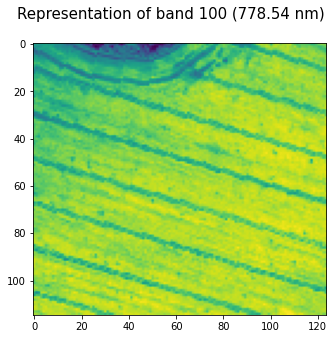

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]
with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs.imshow(arr[band_id].data)
#axs[1].imshow(arr[band_id])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

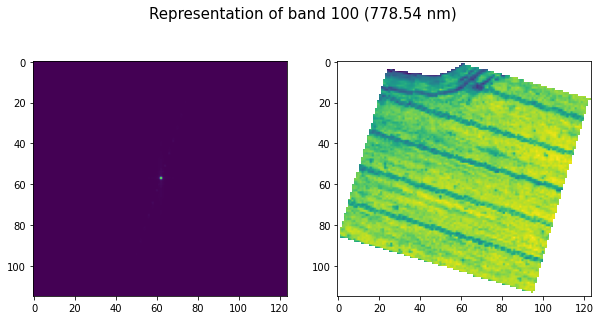

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]
with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

#axs[0].imshow(arr[band_id].data)
axs[0].imshow(abs(np.fft.fftshift(np.fft.fft2(arr[band_id]))))
axs[1].imshow(arr[band_id])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]
with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs[0].imshow(arr[band_id].data)
axs[1].imshow(arr[band_id])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()## Displaying the aggregated spectral curve for a field

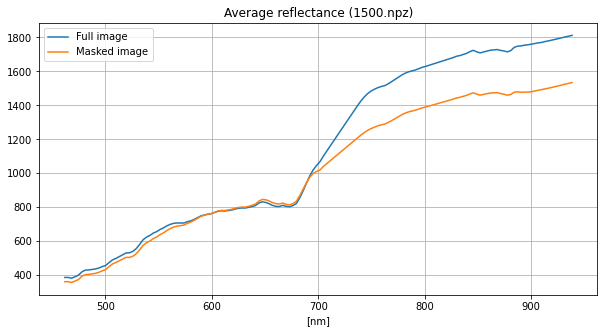

In [20]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i].data.mean() for i in range(arr.shape[0])]
masked_fft=abs(np.fft.fftshift(np.fft.fft(masked_scene_mean_spectral_reflectance)))/100
plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.grid()
plt.show()

# Generating baseline solution

Explanation:

## BaselineRegressor:

The fit function:

Takes the ground truth table of the training data set and computes the mean value of each soil Parameter.Let us denote the vector containing these mean values as X = [ X1,X2,X3,X4 ]  where X<sub>i</sub> denotes the mean of the  i<sup>th</sup> soil paramater (P,K,Mg,pH).

The predict function:

Takes a test/validation set of images(say n images) and returns a matrix of shape (n x 4).Each row 'i' represents a prediction for the soil parameters of the i<sup>th</sup> image.
NOTE:The BaselineRegressor will predict the same value for all images i.e it will always predict the paramters of each image to be the vector X.


In [21]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]  #len=4
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


## Load the data

In [22]:
import os
from glob import glob

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
        arr = filtering(arr)
        data.append(arr)
    return np.array(data)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels


X_train = load_data("train_data")
y_train = load_gt("train_gt.csv")
X_test = load_data("test_data")
#print(X_train)
#print(y_train)
print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Train data shape: (1732, 150)
Test data shape: (1154, 150)


## Make predictions and generate submission file

In [23]:
baseline_reg = BaselineRegressor()
baseline_reg = baseline_reg.fit(X_train, y_train)
predictions = baseline_reg.predict(X_test)

submission = pd.DataFrame(data = predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv("submission.csv", index_label="sample_index")


Note that all the predictions of the soil parameters for the test set are the same.

In [26]:
predictions

array([[ 70.30265589, 227.98851039, 159.28123557,   6.7827194 ],
       [ 70.30265589, 227.98851039, 159.28123557,   6.7827194 ],
       [ 70.30265589, 227.98851039, 159.28123557,   6.7827194 ],
       ...,
       [ 70.30265589, 227.98851039, 159.28123557,   6.7827194 ],
       [ 70.30265589, 227.98851039, 159.28123557,   6.7827194 ],
       [ 70.30265589, 227.98851039, 159.28123557,   6.7827194 ]])

## Calculating the metric

Suppose a model has been trained on the training data.Its metrics is calculated as follows:

Step 1: using the 'fit' method of the BaselineRegressor compute the vector 'X'.(Refer to fit above).

Step 2: Feed in the test/validation image set for predictions(say n images).The 'predict' method of the BaselineRegressor generates a matrix of shape(n x 4) where each row corresponds to the vector 'X'.

Step 3: Compute the 'baselines'(which is a vector of length 4) by computing the MSE of each soil parameter with the ground truth table value of that parameter.

Step 4: generate model predictions (n x 4).Use these predictions to compute its MSE with the ground truth table.We call this new vector containing the MSEs as 'mse'.

Step 5: Score for each parameter is found as mse[i]/baseline[i].Final score is found by computing the mean of scores for all 4 soil parameters.


In the following cell we generate predictions(of a hypothetical model which is equivalent to guessing a certain value in a range of given values.) The metrics of this model then is computed using the ground truth values and the 'baselines'.|

For the purpose of presenting the final metric calculation, we will extract a small _test_set_ from the training set.

In [29]:
X_test = X_train[1500:]
#print(X_test.shape)
y_test = y_train[1500:]
X_train_new = X_train[:1500]
y_train_new = y_train[:1500]

# Fit the baseline regressor once again on new training set
baseline_reg = baseline_reg.fit(X_train_new, y_train_new)
baseline_predictions = baseline_reg.predict(X_test)

# Generate baseline values to be used in score computation
baselines = np.mean((y_test - baseline_predictions) ** 2, axis=0)


# Generate random predictions, different from baseline predictions
np.random.seed(0)
predictions = np.zeros_like(y_test)
for column_index in range(predictions.shape[1]):
    class_mean_value = baseline_reg.mean[column_index]
    predictions[:, column_index] = np.random.uniform(low=class_mean_value - class_mean_value * 0.05,
                                                     high=class_mean_value + class_mean_value * 0.05,
                                                     size=len(predictions))

# Calculate MSE for each class
mse = np.mean((y_test - predictions) ** 2, axis=0)

# Calculate the score for each class individually
scores = mse / baselines

# Calculate the final score
final_score = np.mean(scores)

for score, class_name in zip(scores, ["P", "K", "Mg", "pH"]):
    print(f"Class {class_name} score: {score}")

print(f"Final score: {final_score}")

Class P score: 0.9896068600445717
Class K score: 1.004900913045855
Class Mg score: 1.0228518828521695
Class pH score: 1.6431314552511207
Final score: 1.1651227777984292


In [ ]:
X=[x1,x2,x3,x4]   =>  K = U~(x1 - 0.05x1),(x1 + 0.05x2)

In [30]:
predictions

array([[ 71.14492969, 234.60896263, 156.54226265,   6.58820944],
       [ 72.3228597 , 223.07457321, 155.4820023 ,   6.47165185],
       [ 71.52689119, 227.3321876 , 159.94202674,   6.8109193 ],
       [ 71.11710328, 232.41899705, 157.61388887,   7.03161959],
       [ 70.2588144 , 231.23601154, 166.20990936,   6.71238485],
       [ 71.83225393, 233.32973267, 156.54121103,   6.61016675],
       [ 70.35745495, 228.9751816 , 160.79561225,   6.51340133],
       [ 73.57306006, 236.21507288, 167.87205003,   6.51665031],
       [ 74.08203477, 242.70360337, 162.91130947,   6.60916915],
       [ 69.97410706, 225.22598979, 166.66164164,   6.52664636],
       [ 72.86472715, 234.58972201, 167.83388771,   6.63884036],
       [ 71.00390744, 225.56640368, 164.78842571,   6.50362324],
       [ 71.28108429, 239.26121262, 163.96551279,   6.50325299],
       [ 73.81252916, 231.74863104, 168.28008342,   7.04079721],
       [ 67.76229722, 235.7147875 , 168.70504866,   6.56886976],
       [ 67.8762363 , 226